In [1]:
import os
import torch
import numpy as np 
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision import transforms
from tqdm.notebook import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from improved_precision_recall import IPR 

from dataset import init_dataset
from utils import interpolate

In [2]:
from config import EvalConfig
config = EvalConfig()

# Dataset

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor()
])

test_dataset = init_dataset('mnist', preprocess, 'train', labels=config.labels)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=config.eval_batch_size, shuffle=False)

Number of examples in the train split: 12700


# Evaluation

In [11]:
# Load all fake images from directory into a tensor
fake_images_dir = f'./{config.pretrained_model_dir}/{config.folder_name}'
y_fake = [read_image(f'{fake_images_dir}/{i}') for i in os.listdir(fake_images_dir)]
y_fake = torch.stack(y_fake)

# Load all real images of test_dataloader into a tensor
y_real = torch.cat([batch["image"] for batch in test_dataloader], dim=0)

# Select the same number of real images as fake images
n_images = min(len(y_fake), len(y_real))
y_fake, y_real = y_fake[:n_images], y_real[:n_images]

print(f'Number of real images: {y_real.shape[0]}')
print(f'Number of fake images: {y_fake.shape[0]}')

Number of real images: 4096
Number of fake images: 4096


### Frechet Inception Distance (FID)

* Requires directory of fake images

In [ ]:
# Interpolate images to 299x299 and convert to RGB
y_real_ = interpolate(y_real, mode='RGB', size=299)
y_fake_ = interpolate(y_fake, mode='RGB', size=299)

_ = torch.manual_seed(123)

fid = FrechetInceptionDistance(feature=2048, normalize=True)

# iterate over batch of images
bs = config.eval_batch_size
for b_idx in tqdm(range(0, y_real_.shape[0], bs), desc='Calculating FID...'):
    fid.update(y_real_[b_idx : b_idx + bs], real=True)
    fid.update(y_fake_[b_idx : b_idx + bs], real=False)

print(fid.compute())
fid.reset()

### Precision Recall

In [ ]:
ipr = IPR(batch_size=config.eval_batch_size, k=3, num_samples=y_real_.shape[0])

ipr.compute_manifold_ref(y_real_[:ipr.num_samples])
metric = ipr.precision_and_recall(y_fake_[:ipr.num_samples])
r_score = ipr.realism(y_fake_[:ipr.num_samples])

print('precision =', metric.precision)
print('recall =', metric.recall)
print('realism =', r_score)

### Classifier

In [ ]:
x = next(iter(test_dataloader))['image']
x = x[4]
print(x.mean(), x.min(), x.max())

y = y_fake[4].float()
print(y.mean(), y.min(), y.max())
y = y / 255.0
print(y.mean(), y.min(), y.max())

plt.imshow(y.permute(1, 2, 0))

In [ ]:
from torchvision import transforms, models

# Define the model
model = models.resnet50(pretrained=True)
# Change the first and last layer
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(2048, 10, bias=True)
model = model.to(config.device)
# Load pretrained model
model.load_state_dict(torch.load('./results/mnist-classifier.pth'))

### Visualize

Text(0.5, 1.0, 'Real images')

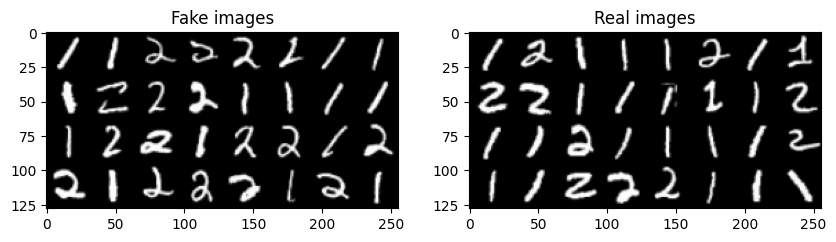

In [7]:
import matplotlib.pyplot as plt
from diffusers.utils import make_image_grid

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fakes = [transforms.ToPILImage()(image) for image in y_fake[:32]]
grid = make_image_grid(fakes, rows=4, cols=8)
axes[0].imshow(grid); axes[0].set_title(f'Fake images')

reals = [transforms.ToPILImage()(image) for image in y_real[:32]]
grid = make_image_grid(reals, rows=4, cols=8)
axes[1].imshow(grid); axes[1].set_title(f'Real images')